# Catégorisez les produits d'un site d'e-commerce: Extraction des features textes

* [1. Import et chargement des données](#10)
    * [1.1 Import des librairies](#11)
    * [1.2 Chargement des données](#12)
    * [1.3 Transformation des labels](#13)
    * [1.4 Préprocessing des données textuelles](#14)
* [3. Extraction des features avec des modèles d'embedding](#30)
    * [3.1 Extraction des features avec BERT ](#31)
    * [3.1b Classification des embeddings de BERT](#31b)
    * [3.2 Extraction des features avec USE](#32)
* [4. Conclusion](#40)

<h1 id="10">1. Import et chargement des données</h1>

<h2 id="11">1.1 Import des librairies</h2>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter

#préprocessing du texte
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#import BoWs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Réduction des dimensions et classification non-supervisée
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



#Deep Learning Embedding
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
from transformers import AutoTokenizer, TFAutoModel

#Universal Sentence Encoder
import tensorflow_hub as hub

#Word2Vec
import gensim

c:\Users\petit\anaconda3\envs\llm_test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#vérification de la version de NumPy (1.2x.x)
np.__version__

'1.26.4'

<h2>1.2 Chargement des données</h2>

In [3]:
df = pd.read_csv("flipkart\\flipkart_com-ecommerce_sample_1050.csv")
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


<h2 id='13'>1.3 Transformation des labels</h2>

In [4]:
df["main_category"] = df['product_category_tree'].str.split(" >> ").str[0].str.replace('["', '')
df['main_category'].value_counts()

main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

<h2 id='14'>1.4 Préprocessing des données textuelles</h2>

In [5]:
def tokenize_bow(sentence:str):
    sentence = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence)
    
    stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

    filtered_w = [w for w in word_tokens if not w in stop_w]
    filtered_w = [w.lower() for w in filtered_w if len(w) > 2]

    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in filtered_w]

    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


def tokenize_dl(sentence:str):
    sentence = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence)
    
    filtered_w = [w.lower() for w in word_tokens if len(w) > 2]

    transf_desc_text = ' '.join(filtered_w)
    return transf_desc_text

In [6]:
df['name_description'] = df['product_name'] + ' ' + df['description']

In [7]:
df['preprocessed_bow'] = [tokenize_bow(s) for s in df['name_description']]
df['preprocessed_dl'] = [tokenize_dl(s) for s in df['name_description']]

In [8]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_category,name_description,preprocessed_bow,preprocessed_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Sathiyas Cotton Bath Towel Specifications of S...,sathiyas cotton bath towel specification sathi...,sathiyas cotton bath towel specifications sath...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Eurospa Cotton Terry Face Towel Set Key Featur...,eurospa cotton terry face towel set key featur...,eurospa cotton terry face towel set key featur...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Jaipur Print Cotton Floral King sized Double B...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...


In [10]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
nums_labels = df['main_category'].nunique()

def ARI_fct(features):
    nums_labels = df['main_category'].nunique()
    time1 = perf_counter()
    tsne = TSNE(n_components=2, perplexity=30, max_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=nums_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(adjusted_rand_score(df['main_category'], cls.labels_),3)
    time2 = np.round(perf_counter() - time1)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, nums_labels, labels, ARI):
    nums_labels = df['main_category'].nunique()
    fig, ax = plt.subplots(1,2,figsize=(15,6))
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['main_category'], ax=ax[0])
    ax[0].set_title('Représentation des produits par catégories réelles')
    
    cat_labels = [str(l) for l in labels]
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=cat_labels, ax=ax[1])
    ax[1].set_title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

<h1 id='30'>Extraction des features avec des modèles d'embeddings</h1>

<h2 id='31'>3.1 Extraction des feeatures avec BERT</h2>

In [13]:
os.environ["TF_KERAS"]='1'

In [14]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = perf_counter()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(perf_counter() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [15]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['preprocessed_dl'].to_list()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [16]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 316ms/step
temps traitement :  47.0


In [17]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.381 time :  5.0


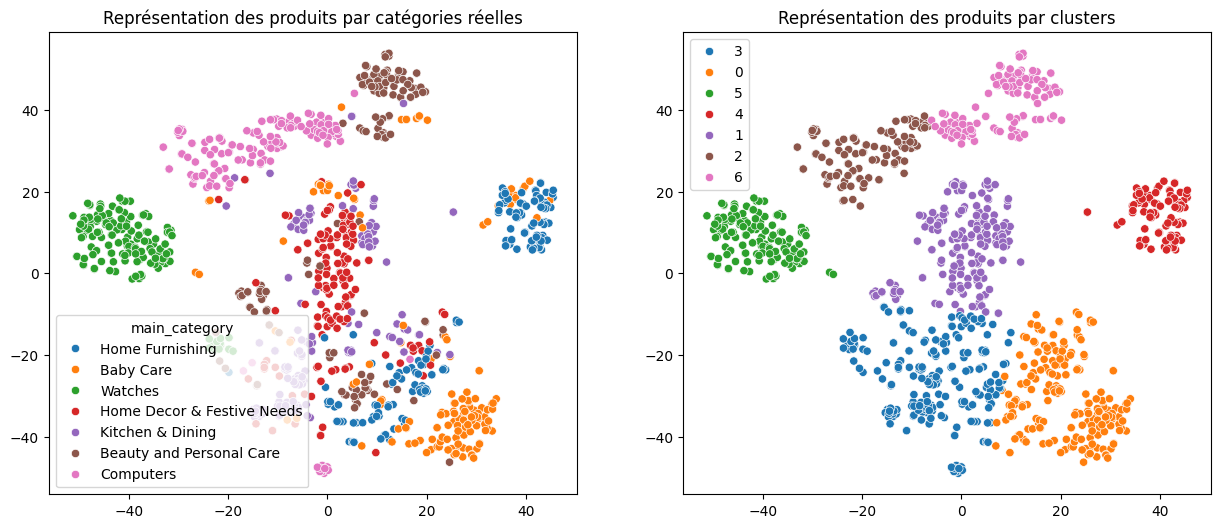

ARI :  0.381


In [18]:
TSNE_visu_fct(X_tsne, nums_labels, labels, ARI)

In [19]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

cat_dict = {key:value for value, key in enumerate(df['main_category'].unique())}

y_list = [cat_dict[cat] for cat in df['main_category']]

y = to_categorical(y_list, num_classes=7)


X_train, X_test, y_train, y_test = train_test_split(features_bert, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25,
                                                  random_state=42,
                                                  stratify=y_train)

In [21]:
h = model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              batch_size=128,
              epochs=5)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2871 - loss: 1.8488 - val_accuracy: 0.7190 - val_loss: 1.2746
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7849 - loss: 1.1177 - val_accuracy: 0.7857 - val_loss: 0.8224
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8464 - loss: 0.6528 - val_accuracy: 0.8190 - val_loss: 0.5989
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8824 - loss: 0.4597 - val_accuracy: 0.8571 - val_loss: 0.4731
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9037 - loss: 0.3336 - val_accuracy: 0.8762 - val_loss: 0.4107


In [22]:
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [23]:
y_pred[0]

y_cat = [np.argmax(pred) for pred in y_pred]

reverse_dic = {value: key for key, value in cat_dict.items()}

y_cat = [reverse_dic[cat] for cat in y_cat]
y_test = [np.argmax(y) for y in y_test]
y_test = [reverse_dic[cat] for cat in y_test]

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
round(accuracy_score(y_test, y_cat), 2)

In [ ]:
print(classification_report(y_test, y_cat))

                            precision    recall  f1-score   support

                 Baby Care       0.73      0.92      0.81        24
  Beauty and Personal Care       0.77      0.88      0.82        26
                 Computers       1.00      0.88      0.94        34
Home Decor & Festive Needs       0.90      0.73      0.81        37
           Home Furnishing       0.87      0.90      0.88        29
          Kitchen & Dining       0.93      0.93      0.93        30
                   Watches       1.00      1.00      1.00        30

                  accuracy                           0.89       210
                 macro avg       0.89      0.89      0.88       210
              weighted avg       0.90      0.89      0.89       210



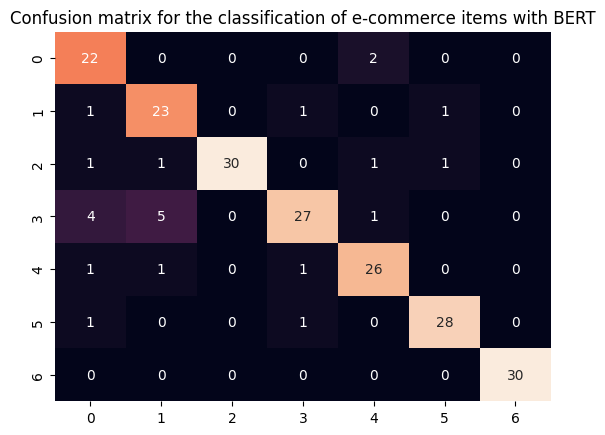

In [ ]:
conf_mat = confusion_matrix(y_test, y_cat)

sns.heatmap(conf_mat, annot=True, cbar=None)
plt.title("Confusion matrix for the classification of e-commerce items with BERT");

In [27]:
stop here :p

SyntaxError: invalid syntax (2948207181.py, line 1)

<h2 id='32'>3.2 Extraction des features avec USE (Universal Sentence Encoder)</h2>

In [ ]:
os.environ["TF_KERAS"]='1'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.model_download("google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder")

print("Path to model files:", path)


100%|██████████| 3.11k/3.11k [00:00<00:00, 1.59MB/s]








100%|██████████| 7.84M/7.84M [00:01<00:00, 5.87MB/s]
100%|██████████| 980M/980M [01:30<00:00, 11.4MB/s]

Path to model files: C:\Users\petit\.cache\kagglehub\models\google\universal-sentence-encoder\tensorFlow2\universal-sentence-encoder\2


In [ ]:
embed = hub.load(path)#"https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = perf_counter()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(perf_counter() - time1)
    return features

In [ ]:
batch_size = 10
sentences = df['preprocessed_dl'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.436 time :  6.0


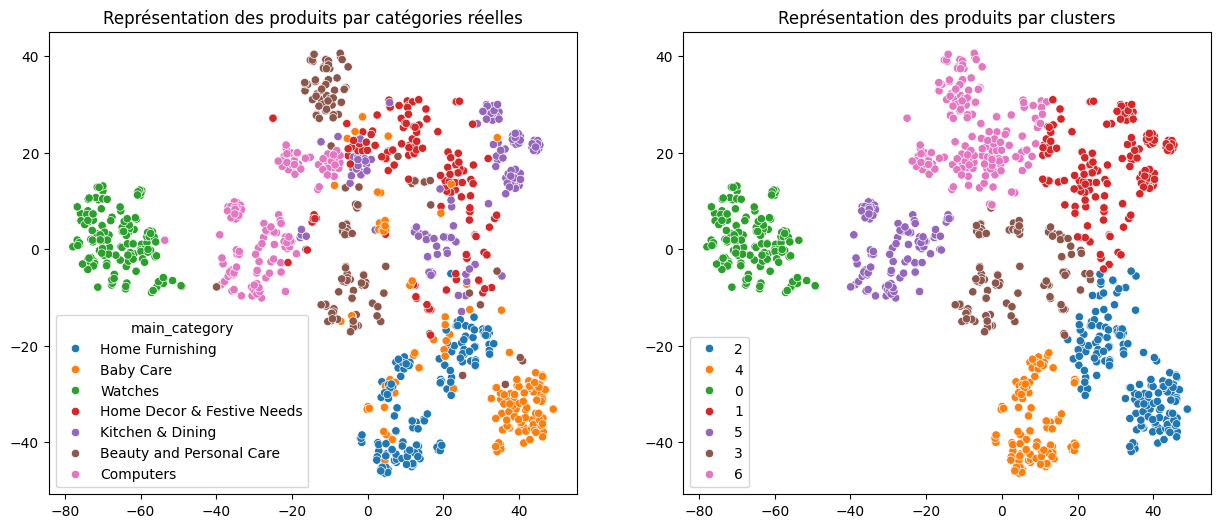

ARI :  0.436


In [ ]:
TSNE_visu_fct(X_tsne, nums_labels, labels, ARI)